# Ion channel challenge: Ensemble methods best models
We made 80+ submissions for this Kaggle competition (see details in the report placed in the project's [github repository](https://github.com/bd3thier/Ion-channels)). This notebook goes over a few models, but not all of them:
* A typical catboost workflow, with models 33 to 35 as an example (model 35 had the highest score of all the submissions), 
* Model 82, which we used for the final submission to the competition,
* And models 75-77, which were our second best group of models. This part of the notebook also features the investigation of where our model fails.

Other steps of the project were described in separate notebooks: [EDA](https://github.com/bd3thier/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20data%20wrangling%20and%20EDA.ipynb), Feature Engineering ([features for models 33-35](https://github.com/bd3thier/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Feature%20Engineering%201.ipynb), [main, most complete notebook with features for model 82](https://github.com/bd3thier/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Feature%20engineering%203.ipynb), and [features for models 75-77](https://github.com/bd3thier/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Feature%20engineering%202.ipynb)), and [Neural Nets]() (coming soon). Note that all the feature engineering is not presented in the notebook, only a representative example (we generated 7 sets of features during the course of the project).

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import catboost
from catboost import *

In [2]:
# from https://www.kaggle.com/kmat2019/u-net-1d-cnn-with-keras
def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':

                if (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df

In [3]:
def batch_f1_score(X, y, model):
    X_batch_1s = X[0:1000000]
    y_batch_1s = y[0:1000000]
    pred_batch_1s = model.predict(X_batch_1s)
    print("Macro F1 score batch 1s: ", np.round(f1_score(y_batch_1s, pred_batch_1s, average="macro"), 5))
    
    X_batch_1f = pd.concat([X[1000000:1500000],X[3000000:3500000]], axis = 0 )
    y_batch_1f = pd.concat([y[1000000:1500000],y[3000000:3500000]], axis = 0 )  
    pred_batch_1f = model.predict(X_batch_1f)
    print("Macro F1 score batch 1f: ", np.round(f1_score(y_batch_1f, pred_batch_1f, average="macro"), 5))
    
    X_batch_3 = pd.concat([X[1500000:2000000],X[3500000:4000000]], axis = 0 )
    y_batch_3 = pd.concat([y[1500000:2000000],y[3500000:4000000]], axis = 0 )  
    pred_batch_3 = model.predict(X_batch_3)
    print("Macro F1 score batch 3: ", np.round(f1_score(y_batch_3, pred_batch_3, average="macro"), 5))
    
    X_batch_5 = pd.concat([X[2500000:3000000],X[4000000:4500000]], axis = 0 )
    y_batch_5 = pd.concat([y[2500000:3000000],y[4000000:4500000]], axis = 0 )  
    pred_batch_5 = model.predict(X_batch_5)
    print("Macro F1 score batch 5: ", np.round(f1_score(y_batch_5, pred_batch_5, average="macro"), 5))
    
    X_batch_10 = pd.concat([X[2000000:2500000],X[4500000:5000000]], axis = 0 )
    y_batch_10 = pd.concat([y[2000000:2500000],y[4500000:5000000]], axis = 0 )  
    pred_batch_10 = model.predict(X_batch_10)
    print("Macro F1 score batch 10: ", np.round(f1_score(y_batch_10, pred_batch_10, average="macro"), 5))
    
    return pred_batch_1s, pred_batch_1f, pred_batch_3, pred_batch_5, pred_batch_10

## Load data: features 

In [4]:
# Load data
# Notebook 
train = pd.read_csv('../data/interim/6thset_train.csv', index_col =0)
test = pd.read_csv('../data/interim/6thset_test.csv', index_col =0)

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
# peak_detected feature is imported from EDA notebook
test['peak_detected'] = pd.read_csv('../data/interim/test_peak_detected_prominence1.csv')
train['peak_detected'] = pd.read_csv('../data/interim/train_peak_detected_prominence1.csv')

In [6]:
y = train.open_channels
X = train.drop(['open_channels', 'signal_norm'], axis=1) # signal_norm was inherited from previous attempts
del train

In [7]:
X_test = test.copy()
X_test = X_test.drop('signal_norm', axis=1)
del test 

In [8]:
# for the train dataset, reduce_mem_usage was applied when the features were first generated. We wanted to
# avoid it for the test set since 'time' needed to be in the originsal format for submission
# In the end, we need the other features in the same format as train, so we apply reduce_mem_usage then replace 'time'
X_test = reduce_mem_usage(X_test)

Mem. usage decreased to 747.68 MB (65.2 % reduction)


In [9]:
# When we reduce the memory usage the time is rounded up and that creates format issues when submitting 
test_raw = pd.read_csv('../data/raw/test.csv')
X_test['time']=test_raw['time']
del test_raw

## Set up catboost

In [10]:
categorical = ['peak_detected']

In [11]:
X[categorical] = X[categorical].astype(str)

In [12]:
X.dtypes

time                   float64
signal                 float64
mean_5_r               float64
mean_5_c               float64
std_5_r                float64
                        ...   
deriv_lag+3            float64
exp                    float64
integration            float64
integration_shift10    float64
peak_detected           object
Length: 140, dtype: object

In [13]:
X_test[categorical] = X_test[categorical].astype(str)

In [14]:
cat_features = [X.columns.get_loc(i) for i in categorical]
cat_features

[139]

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=134)

## Models 33 to 35: Catboost with 142 features

### Model 33: peak_detected and features generated with no signal normalization
Back story: we had to normalize the signal to generate one feature, and we are now building a model with all the features generated from the original signal. 

Model 33 is the first model where:
* We include the integration and lag10 of integration (only features calculated on signal normalized per batch, all the other are calculated on the original signal)
* We include the peak_detected feature, a bool returning True if scipy find_peaks function identified a peak


In [16]:
# Create Classifier, train the model
model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    depth= 6,
    l2_leaf_reg= 9,
    random_strength= 1,
    task_type = 'GPU',
    loss_function='MultiClass',
    custom_metric = 'TotalF1'

)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=1000, 
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6226089	test: 1.6228611	best: 1.6228611 (0)	total: 231ms	remaining: 19m 15s
1000:	learn: 0.0792905	test: 0.0814269	best: 0.0814269 (1000)	total: 2m 56s	remaining: 11m 44s
2000:	learn: 0.0763126	test: 0.0807988	best: 0.0807987 (1999)	total: 5m 52s	remaining: 8m 48s
3000:	learn: 0.0737641	test: 0.0806005	best: 0.0805992 (2989)	total: 8m 49s	remaining: 5m 52s
4000:	learn: 0.0715088	test: 0.0805641	best: 0.0805629 (3998)	total: 11m 46s	remaining: 2m 56s
4999:	learn: 0.0693554	test: 0.0805540	best: 0.0805512 (4977)	total: 14m 43s	remaining: 0us
bestTest = 0.08055123438
bestIteration = 4977
Shrink model to first 4978 iterations.


In [17]:
# Evaluate the model
pred = model.predict(X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.93905


In [18]:
# Score per batch
batch_f1_score(X, y, model)

Macro F1 score batch 1s:  0.99745
Macro F1 score batch 1f:  0.99711
Macro F1 score batch 3:  0.98098
Macro F1 score batch 5:  0.83641
Macro F1 score batch 10:  0.88624


(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=int64),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=int64),
 array([[3],
        [3],
        [3],
        ...,
        [2],
        [1],
        [2]], dtype=int64),
 array([[7],
        [5],
        [5],
        ...,
        [4],
        [4],
        [3]], dtype=int64),
 array([[10],
        [10],
        [10],
        ...,
        [ 8],
        [ 9],
        [ 9]], dtype=int64))

In [19]:
# Predict open_channels for X_test
X_test['open_channels']=np.round(model.predict(X_test), 0)
X_test.head()

time    signal  mean_5_r  mean_5_c   std_5_r   std_5_c   min_5_r  \
0  500.0001 -2.650391       NaN       NaN       NaN       NaN       NaN   
1  500.0002 -2.845703       NaN       NaN       NaN       NaN       NaN   
2  500.0003 -2.853516       NaN -2.681641       NaN  0.172607       NaN   
3  500.0004 -2.443359       NaN -2.666016       NaN  0.179932       NaN   
4  500.0005 -2.613281 -2.681641 -2.642578  0.172607  0.157471 -2.853516   

    min_5_c   max_5_r   max_5_c  ...     deriv  deriv_lag-1  deriv_lag-3  \
0       NaN       NaN       NaN  ... -0.195312          NaN          NaN   
1       NaN       NaN       NaN  ... -0.101257    -0.195312          NaN   
2 -2.853516       NaN -2.443359  ...  0.201416    -0.101257          NaN   
3 -2.853516       NaN -2.443359  ...  0.120667     0.201416    -0.195312   
4 -2.853516 -2.443359 -2.443359  ... -0.062683     0.120667    -0.101257   

   deriv_lag+1  deriv_lag+3       exp  integration  integration_shift10  \
0    -0.101257     0.120667  0.070557    -1.574542                  NaN   
1     0.201416    -0.062683  0.058044    -3.344384                  NaN   
2     0.120667    -0.061859  0.057617    -5.121427                  NaN   
3    -0.062683    -0.105042  0.086853    -6.488469                  NaN   
4    -0.061859    -0.052094  0.073364    -8.024211                  NaN   

   peak_detected  open_channels  
0          False              0  
1          False              0  
2          False              0  
3          False              0  
4          False              0  

[5 rows x 141 columns]

In [20]:
# Save the two columns of interest for submission
X_test[['time','open_channels']].to_csv('../reports/ion_submission_catclass3.2_2.1.4.csv', 
                                                  index=False, float_format='%.4f')

The macro F1 score* calculated above is 0.93890, and after submission the model scored 0.940 on the public leaderboard and 0.938 on the private leaderboard. The first two numbers (the only ones available at the time of the competition) were very close, which was encouraging: we thought we were not overfitting. 

From the score per batch, we see that the model performs really well for batches 1-3, not so well for batches 5 and 10.

*We did not calculate a CV score, relying on the leaderboard score (based on a test set) more than what we calculated. Still, this macro F1 score is computed for X_validation, not the whole training set, to see how the model generalizes

### Submission 34 - 95% feature importance

In [21]:
# Get feature importance - save it for future use
pd.DataFrame(model.get_feature_importance(prettified=True, type = 'PredictionValuesChange')).to_csv('../notebooks/2.1.4 Feature importance')
model.get_feature_importance(prettified=True, type = 'PredictionValuesChange')


Feature Id  Importances
0                         exp     7.716621
1                      power2     6.998642
2                      sqroot     6.682706
3                      signal     5.846798
4        min_max_ratio_1215_c     3.751657
..                        ...          ...
135               mean_405_ew     0.135115
136    min_max_ratio_mean_5_r     0.116228
137  min_max_ratio_mean_135_r     0.107832
138  min_max_ratio_mean_405_c     0.104423
139             peak_detected     0.046583

[140 rows x 2 columns]

In [22]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, 
                                      model.get_feature_importance())),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', 
                                          na_position='last')

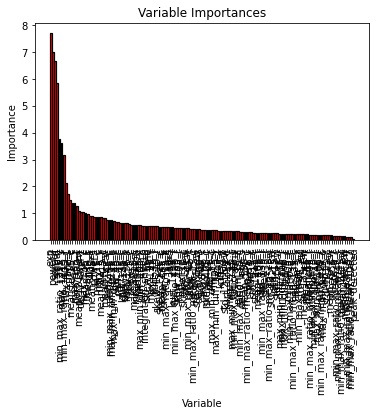

In [23]:
# list of x locations for plotting
x_values = list(range(len(feature_score)))
# Make a bar chart
plt.bar(x_values, feature_score['Score'], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_score['Feature'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

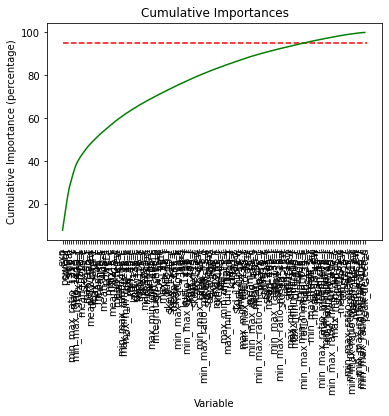

In [24]:
# Cumulative importances
cumulative_importances = np.cumsum(feature_score['Score'])
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(feature_score['Score']), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, feature_score['Feature'], rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance (percentage)'); plt.title('Cumulative Importances');

In [25]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
threshold= np.where(cumulative_importances > 95)[0][0] + 1
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 112


In [26]:
# List of features for later use
feature_list = list(X.columns)
# Extract the names of the most important features
important_feature_names = feature_score[0:threshold]['Feature']
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_X_train = X_train.iloc[:, important_indices]
important_X_validation = X_validation.iloc[:, important_indices]
important_X_test = X_test.iloc[:, important_indices]
important_X =  X.iloc[:, important_indices]
# Sanity check on operations
print('Important train subset features shape:', important_X_train.shape)
print('Important validation subset features shape:', important_X_validation.shape)
print('Important test features shape:', important_X_test.shape)
print('Important train set features shape:', important_X.shape)

Important train subset features shape: (4000000, 112)
Important validation subset features shape: (1000000, 112)
Important test features shape: (2000000, 112)
Important train set features shape: (5000000, 112)


In [27]:
# peak_detected, the only categorical feature, was not in the 95%
#cat_features = [important_X.columns.get_loc(i) for i in categorical]
#cat_features

In [28]:
# Create classifier, train 
model4 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.05,
    depth= 10,
    l2_leaf_reg= 9,
    random_strength= 10,
    task_type = 'GPU',
    loss_function='MultiClass',
    custom_metric = 'TotalF1'

)
model4.fit(
    important_X_train, y_train,
    cat_features=None,
    eval_set=(important_X_validation, y_validation),
    verbose=1000, 
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9598886	test: 1.9601295	best: 1.9601295 (0)	total: 183ms	remaining: 15m 14s
1000:	learn: 0.0761270	test: 0.0814343	best: 0.0814343 (1000)	total: 3m 16s	remaining: 13m 4s
2000:	learn: 0.0689437	test: 0.0807003	best: 0.0807003 (2000)	total: 6m 41s	remaining: 10m 1s
3000:	learn: 0.0628593	test: 0.0805431	best: 0.0805413 (2937)	total: 10m 8s	remaining: 6m 45s
4000:	learn: 0.0575309	test: 0.0805533	best: 0.0805298 (3300)	total: 13m 35s	remaining: 3m 23s
4999:	learn: 0.0526588	test: 0.0806954	best: 0.0805298 (3300)	total: 17m 4s	remaining: 0us
bestTest = 0.0805298125
bestIteration = 3300
Shrink model to first 3301 iterations.


In [29]:
# Evaluate the model
pred = model4.predict(important_X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.93897


In [32]:
# Score per batch
batch_f1_score(important_X, y, model4)

Macro F1 score batch 1s:  0.99767
Macro F1 score batch 1f:  0.99713
Macro F1 score batch 3:  0.98278
Macro F1 score batch 5:  0.97738
Macro F1 score batch 10:  0.90339


(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=int64),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=int64),
 array([[3],
        [3],
        [3],
        ...,
        [2],
        [1],
        [2]], dtype=int64),
 array([[5],
        [5],
        [5],
        ...,
        [4],
        [4],
        [3]], dtype=int64),
 array([[10],
        [10],
        [10],
        ...,
        [ 8],
        [ 9],
        [ 9]], dtype=int64))

In [33]:
# Predict number of open_channels
important_X_test['open_channels']=np.round(model4.predict(important_X_test), 0)
important_X_test.head()

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


exp    power2  sqroot    signal  min_max_ratio_1215_c  max_1215_r  \
0  0.070557  7.031250     NaN -2.650391                   NaN         NaN   
1  0.058044  8.101562     NaN -2.845703                   NaN         NaN   
2  0.057617  8.140625     NaN -2.853516                   NaN         NaN   
3  0.086853  5.972656     NaN -2.443359                   NaN         NaN   
4  0.073364  6.824219     NaN -2.613281                   NaN         NaN   

   min_max_ratio_1215_r  max_405_c     lag+1  mean_1215_c  ...  min_15_r  \
0                   NaN        NaN -2.845703          NaN  ...       NaN   
1                   NaN        NaN -2.853516          NaN  ...       NaN   
2                   NaN        NaN -2.443359          NaN  ...       NaN   
3                   NaN        NaN -2.613281          NaN  ...       NaN   
4                   NaN        NaN -2.568359          NaN  ...       NaN   

   std_15_ew  max_min_diff_135_r  max_min_diff_15_r  max_min_diff_405_r  \
0        NaN                 NaN                NaN                 NaN   
1   0.138062                 NaN                NaN                 NaN   
2   0.111084                 NaN                NaN                 NaN   
3   0.205322                 NaN                NaN                 NaN   
4   0.175415                 NaN                NaN                 NaN   

    std_5_c  min_405_c  min_max_ratio_5_c  min_max_ratio_mean_135_c  \
0       NaN        NaN                NaN                       NaN   
1       NaN        NaN                NaN                       NaN   
2  0.172607        NaN          -0.143668                       NaN   
3  0.179932        NaN          -0.167772                       NaN   
4  0.157471        NaN          -0.156938                       NaN   

   open_channels  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 113 columns]

In [34]:
# Export csv file for submission
important_X_test[['time','open_channels']].to_csv('../reports/ion_submission_catclass4.2_2.1.3.csv', index=False, float_format='%.4f')

The macro F1 score calculated above is 0.93897, and after submission the model scored 0.940 on the public leaderboard and 0.9385 on the private leaderboard. This is better than the model with all the features. The score per batch indicates that only batch of type 10 is not predicted in the 0.98 range.

We can now tune the hyperparameters:

### Model 35 - tuning the hyperparameters of model 34

In [35]:
param_grid = {'learning_rate': [0.1],
              'depth': [4, 6, 10], # add 4?
              'l2_leaf_reg': [1, 5, 9],
              #'bagging_temperature': [0, 0.5, 1.0],
              'random_strength': [1, 10, 20]} 
model5 = CatBoostClassifier(
    iterations = 3000,
    loss_function = 'MultiClass',
    custom_metric = 'TotalF1',
    verbose = 100,
    task_type = 'GPU')

In [36]:
pool = Pool(data=important_X, label=y, cat_features=None)

In [37]:
grid_search_result = model5.grid_search(param_grid,
            pool,
            cv=3,
            partition_random_seed=134,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0810996	best: 0.0810996 (0)	total: 4m 44s	remaining: 2h 3m 10s
1:	loss: 0.0811621	best: 0.0810996 (0)	total: 9m 23s	remaining: 1h 57m 19s
2:	loss: 0.0811936	best: 0.0810996 (0)	total: 14m 2s	remaining: 1h 52m 17s
3:	loss: 0.0811318	best: 0.0810996 (0)	total: 18m 41s	remaining: 1h 47m 30s
4:	loss: 0.0811460	best: 0.0810996 (0)	total: 23m 13s	remaining: 1h 42m 10s
5:	loss: 0.0811701	best: 0.0810996 (0)	total: 27m 45s	remaining: 1h 37m 8s
6:	loss: 0.0811320	best: 0.0810996 (0)	total: 32m 17s	remaining: 1h 32m 16s
7:	loss: 0.0812034	best: 0.0810996 (0)	total: 36m 49s	remaining: 1h 27m 26s
8:	loss: 0.0812318	best: 0.0810996 (0)	total: 41m 20s	remaining: 1h 22m 41s
9:	loss: 0.0808124	best: 0.0808124 (9)	total: 47m	remaining: 1h 19m 54s
10:	loss: 0.0807301	best: 0.0807301 (10)	total: 52m 38s	remaining: 1h 16m 34s
11:	loss: 0.0807298	best: 0.0807298 (11)	total: 58m 17s	remaining: 1h 12m 51s
12:	loss: 0.0808054	best: 0.0807298 (11)	total: 1h 3m 55s	remaining: 1h 8m 50s
13:	loss: 0.08

In [38]:
# Evaluate the model
pred = model5.predict(important_X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.94439


In [39]:
# Score per batch
batch_f1_score(important_X, y, model5)

Macro F1 score batch 1s:  0.99743
Macro F1 score batch 1f:  0.99707
Macro F1 score batch 3:  0.97956
Macro F1 score batch 5:  0.83606
Macro F1 score batch 10:  0.90777


(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=int64),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=int64),
 array([[3],
        [3],
        [3],
        ...,
        [2],
        [1],
        [2]], dtype=int64),
 array([[7],
        [7],
        [7],
        ...,
        [4],
        [4],
        [3]], dtype=int64),
 array([[10],
        [10],
        [10],
        ...,
        [ 8],
        [ 9],
        [ 9]], dtype=int64))

In [40]:
# Predict open_channels for the test set
important_X_test['open_channels']=np.round(model5.predict(important_X_test), 0)
important_X_test.head()

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


exp    power2  sqroot    signal  min_max_ratio_1215_c  max_1215_r  \
0  0.070557  7.031250     NaN -2.650391                   NaN         NaN   
1  0.058044  8.101562     NaN -2.845703                   NaN         NaN   
2  0.057617  8.140625     NaN -2.853516                   NaN         NaN   
3  0.086853  5.972656     NaN -2.443359                   NaN         NaN   
4  0.073364  6.824219     NaN -2.613281                   NaN         NaN   

   min_max_ratio_1215_r  max_405_c     lag+1  mean_1215_c  ...  min_15_r  \
0                   NaN        NaN -2.845703          NaN  ...       NaN   
1                   NaN        NaN -2.853516          NaN  ...       NaN   
2                   NaN        NaN -2.443359          NaN  ...       NaN   
3                   NaN        NaN -2.613281          NaN  ...       NaN   
4                   NaN        NaN -2.568359          NaN  ...       NaN   

   std_15_ew  max_min_diff_135_r  max_min_diff_15_r  max_min_diff_405_r  \
0        NaN                 NaN                NaN                 NaN   
1   0.138062                 NaN                NaN                 NaN   
2   0.111084                 NaN                NaN                 NaN   
3   0.205322                 NaN                NaN                 NaN   
4   0.175415                 NaN                NaN                 NaN   

    std_5_c  min_405_c  min_max_ratio_5_c  min_max_ratio_mean_135_c  \
0       NaN        NaN                NaN                       NaN   
1       NaN        NaN                NaN                       NaN   
2  0.172607        NaN          -0.143668                       NaN   
3  0.179932        NaN          -0.167772                       NaN   
4  0.157471        NaN          -0.156938                       NaN   

   open_channels  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 113 columns]

In [41]:
# Export for submission
important_X_test[['time','open_channels']].to_csv('../reports/ion_submission_catclass5.2_2.1.4.csv', index=False, float_format='%.4f')

The macro F1 score calculated above is 0.94439, and after submission the model scored 0.940 on the public leaderboard and 0.9387 on the private leaderboard. It constitutes an improvement but we are starting to overfit on the validation set and on the public portion of the test set.
Here again, batch 5 is causing troubles. 

Next we will use a different set of features to try and improve the score.

## Model 82: 
Catboost calssifier with the following characteristics:
* Features generated per batch (unlike previous models of this notebook). The goal was to improve the features at the edges of batches for lag and rolling statistics.
* Square root calculated to avoid NA values.

In [42]:
# Load data
# From Notebook 2.1.7.1
train = pd.read_csv('../data/interim/train_FE_batchKal1.4.csv', index_col =0)
test = pd.read_csv('../data/interim/test_FE_batchKal1.4.csv', index_col =0)

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (140) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
# Get features and label
y = train.open_channels
X = train.drop('open_channels', axis=1)
del train

In [44]:
X_test = test.copy()
del test 

In [45]:
# for the train dataset, reduce_mem_usage was applied when the features were first generated. We wanted to
# avoid it for the test set since 'time' needed to be in the originsal format for submission
# In the end, we need the other features in the same format as train, so we apply reduce_mem_usage then replace 'time'
X_test = reduce_mem_usage(X_test)
test_raw = pd.read_csv('../data/raw/test.csv')
X_test['time']=test_raw['time']
del test_raw

Mem. usage decreased to 743.87 MB (65.2 % reduction)


In [46]:
# Split into train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=13)

In [47]:
# Create and train the classifier
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.05,
    depth= 10, 
    l2_leaf_reg= 9, 
    random_strength= 1, 
    bagging_temperature = 0.5,
    task_type = 'GPU',
    loss_function='MultiClass',
    custom_metric = 'TotalF1'

)
model.fit(X_train, y_train,
    cat_features=None,
    eval_set=(X_validation, y_validation),
    verbose=500, 
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9587817	test: 1.9586851	best: 1.9586851 (0)	total: 194ms	remaining: 16m 7s
500:	learn: 0.0812932	test: 0.0831010	best: 0.0831010 (500)	total: 1m 37s	remaining: 14m 39s
1000:	learn: 0.0763042	test: 0.0814762	best: 0.0814761 (999)	total: 3m 25s	remaining: 13m 42s
1500:	learn: 0.0724836	test: 0.0809710	best: 0.0809710 (1500)	total: 5m 14s	remaining: 12m 13s
2000:	learn: 0.0690789	test: 0.0807150	best: 0.0807150 (2000)	total: 7m 3s	remaining: 10m 35s
2500:	learn: 0.0659460	test: 0.0805837	best: 0.0805837 (2500)	total: 8m 53s	remaining: 8m 52s
3000:	learn: 0.0629997	test: 0.0805224	best: 0.0805168 (2951)	total: 10m 42s	remaining: 7m 8s
3500:	learn: 0.0602268	test: 0.0805017	best: 0.0805015 (3499)	total: 12m 32s	remaining: 5m 22s
4000:	learn: 0.0576246	test: 0.0804774	best: 0.0804722 (3893)	total: 14m 21s	remaining: 3m 35s
4500:	learn: 0.0552108	test: 0.0805069	best: 0.0804722 (3893)	total: 16m 11s	remaining: 1m 47s
4999:	learn: 0.0527902	test: 0.0805604	best: 0.0804722 (3893)	to

In [48]:
# Evaluate model
pred = model.predict(X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.93846


In [49]:
# Score per batch
batch_f1_score(X, y, model)

Macro F1 score batch 1s:  0.99754
Macro F1 score batch 1f:  0.99713
Macro F1 score batch 3:  0.98331
Macro F1 score batch 5:  0.9784
Macro F1 score batch 10:  0.908


(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=int64),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=int64),
 array([[3],
        [3],
        [3],
        ...,
        [2],
        [1],
        [2]], dtype=int64),
 array([[5],
        [5],
        [5],
        ...,
        [4],
        [4],
        [3]], dtype=int64),
 array([[10],
        [10],
        [10],
        ...,
        [ 8],
        [ 9],
        [ 9]], dtype=int64))

In [50]:
# Predict open_channels for test set
X_test['open_channels']=model.predict(X_test)

In [51]:
# Export for submission
X_test[['time','open_channels']].to_csv('../reports/ion_submission_catclass1.2_2.1.7.1.csv', index=False, float_format='%.4f')

The macro F1 score calculated is 0.93846, and after submission the model scored 0.940 on the public leaderboard. It felt like we were not overfitting anymore. However, it scored only 0.9372 on the private leaderboard. 
This model performs better on batch 5 but poorly on batch 10. 

Next we will use a different approach: train a model on batch 5 and 10, then use the predictions as a feature.

We also needed to export several features for our Neural Nets:

In [52]:
#train = pd.read_csv('../data/external/train_kalman.csv')#, index_col =0)
X_test['cat_pred']=model.predict(X_test)
train = pd.read_csv('../data/interim/train_FE_batchKal1.4.csv')
train['cat_pred']= model.predict(X)

In [53]:
# Export selected features as csv
X_test[['time','signal','cat_pred', 'exp', 'power2', 'sqroot']].to_csv('../data/interim/test_2.1.7.1catpred.csv', index=False, float_format='%.4f')
train[['time','signal','open_channels', 'cat_pred', 'exp', 'power2', 'sqroot']].to_csv('../data/interim/train_2.1.7.1catpred.csv', index=False, float_format='%.4f')

## Models 75-77

Idea: Train a model only on the batches that are challenging to predict (2-10 open channels) then use that as a feature in a second model.


In [4]:
# Load data
#From Notebook 2.1.9
#train = pd.read_csv('data/train.csv')
train = pd.read_csv('../data/interim/train_FE_batch.csv', index_col =0)
test = pd.read_csv('../data/interim/test_FE_batch.csv', index_col =0)

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (140) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Select the batches with high number of open channels
y = pd.concat([train[2000000:2500000].open_channels, train[4500000:5000000].open_channels], axis = 0)
X = pd.concat([train[2000000:2500000].drop('open_channels', axis=1), 
               train[4500000:5000000].drop('open_channels', axis=1)], axis = 0)
#del train

In [6]:
X_test =  test.copy()
#del test 

In [7]:
test_raw = pd.read_csv('../data/raw/test.csv')
X_test['time']=test_raw['time']
del test_raw

In [8]:
categorical = ['peak_detected']
X[categorical] = X[categorical].astype(str)
X_test[categorical] = X_test[categorical].astype(str)

In [9]:
cat_features = [X.columns.get_loc(i) for i in categorical]
cat_features

[138]

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=134)

In [11]:
# Parameters from submission 36 - NB 2.1.4 with less iterations
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth= 10, 
    l2_leaf_reg= 9, 
    random_strength= 1, 
    bagging_temperature = 0.5,
    task_type = 'GPU',
    loss_function='MultiClass',
    custom_metric = 'TotalF1'

)
model.fit(X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=500, 
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0205509	test: 2.0206616	best: 2.0206616 (0)	total: 112ms	remaining: 3m 43s
500:	learn: 0.2677944	test: 0.2812060	best: 0.2812060 (500)	total: 1m 6s	remaining: 3m 18s
1000:	learn: 0.2531788	test: 0.2801659	best: 0.2801659 (1000)	total: 2m 15s	remaining: 2m 14s
1500:	learn: 0.2390871	test: 0.2798741	best: 0.2798662 (1441)	total: 3m 26s	remaining: 1m 8s
1999:	learn: 0.2244037	test: 0.2798842	best: 0.2798561 (1618)	total: 4m 39s	remaining: 0us
bestTest = 0.2798561328
bestIteration = 1618
Shrink model to first 1619 iterations.


In [12]:
pred = model.predict(X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.87031


In [13]:
# Check feature importance for the high open_channels to see if anything stands out
feature_score = pd.DataFrame(list(zip(X.dtypes.index, 
                                      model.get_feature_importance(Pool(X_validation, label=y_validation,
                                                                        cat_features=cat_features), 
                                                                   type = 'LossFunctionChange'))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', 
                                          na_position='last')
feature_score.head(20)

Feature     Score
127                power2  0.047874
135                   exp  0.012741
1                  signal  0.010055
128                sqroot  0.004701
125                 lag+1  0.003678
120  min_max_ratio_1215_c  0.003611
117  min_max_ratio_1215_r  0.000858
129                power3  0.000660
9                 max_5_c  0.000630
122                 lag-1  0.000502
7                 min_5_c  0.000340
27               min_15_c  0.000270
60     min_max_ratio_45_c  0.000216
97    min_max_ratio_405_r  0.000162
80    min_max_ratio_135_c  0.000123
55           mean_45_c_ew  0.000122
100   min_max_ratio_405_c  0.000117
20      min_max_ratio_5_c  0.000099
15            mean_5_c_ew  0.000083
35           mean_15_c_ew  0.000078

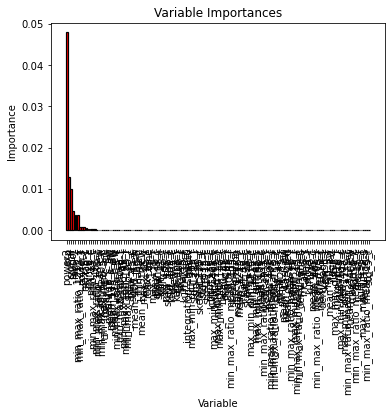

In [14]:
# list of x locations for plotting
x_values = list(range(len(feature_score)))
# Make a bar chart
plt.bar(x_values, feature_score['Score'], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_score['Feature'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

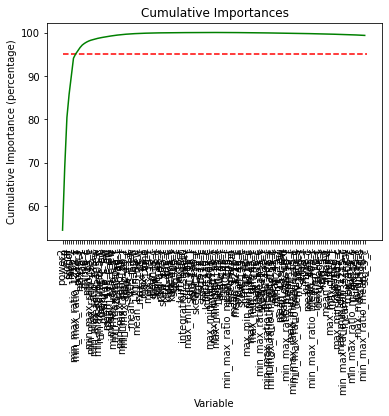

In [15]:
# Cumulative importances
cumulative_importances = np.cumsum(feature_score['Score']/0.087836*100)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(feature_score['Score']), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, feature_score['Feature'], rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance (percentage)'); plt.title('Cumulative Importances');

In [16]:
cumulative_importances

127    54.504057
135    69.009084
1      80.456602
128    85.808498
125    89.996272
         ...    
72     99.450993
19     99.429462
132    99.406979
38     99.379575
5      99.349393
Name: Score, Length: 139, dtype: float64

In [17]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
threshold= np.where(cumulative_importances > 95)[0][0] + 1
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 7


The macro F1 score calculated is 0.8696. It makes sense since it wasn't created for prediction. It wasn't submitted either.

We tried to derive insights from this model to understand what goes into predicting open_channels 2-10.
Interestingly, only 7 features make up 95% of the features importance, and the square of the signal holds 54% of importance! The only rolling statistics on the list of 95% feature importance are for the largest window (1215 timesteps). An even larger window might have improved the predictions.

Now we can train a new model with this new feature (after saving it)

In [18]:
# Create temporary dataframe for predictions
X_temp = train.drop('open_channels', axis=1)
X_temp[categorical] = X_temp[categorical].astype(str)
X_temp.dtypes

time                   float64
signal                 float64
mean_5_r               float64
mean_5_c               float64
std_5_r                float64
                        ...   
deriv_lag+3            float64
exp                    float64
integration            float64
integration_shift10    float64
peak_detected           object
Length: 139, dtype: object

In [19]:
# Predict open_channels using the high_catpred model, save the predictions in a new column of train 
# Do the same for test
train['high_catpred']= model.predict(X_temp)
test['high_catpred']=model.predict(X_test)

In [20]:
train.head()

time  signal  open_channels  mean_5_r  mean_5_c  std_5_r  std_5_c  \
0  0.0001  -2.760              0    -2.760    -2.678      NaN   0.2238   
1  0.0002  -2.848              0    -2.805    -2.791  0.06174   0.2908   
2  0.0003  -2.424              0    -2.678    -2.861  0.22380   0.2974   
3  0.0004  -3.130              0    -2.791    -2.840  0.29080   0.3108   
4  0.0005  -3.145              0    -2.861    -2.809  0.29740   0.3170   

   min_5_r  min_5_c  max_5_r  ...   deriv  deriv_lag-1  deriv_lag-3  \
0   -2.760   -2.848   -2.760  ... -0.0873          NaN          NaN   
1   -2.848   -3.130   -2.760  ...  0.1682      -0.0873          NaN   
2   -2.848   -3.145   -2.424  ... -0.1410       0.1682          NaN   
3   -3.130   -3.145   -2.424  ... -0.3604      -0.1410      -0.0873   
4   -3.145   -3.145   -2.424  ...  0.2400      -0.3604       0.1682   

   deriv_lag+1  deriv_lag+3      exp  integration  integration_shift10  \
0       0.1682      -0.3604  0.06323     -0.07930                  NaN   
1      -0.1410       0.2400  0.05795     -0.24580                  NaN   
2      -0.3604       0.2239  0.08856      0.01122                  NaN   
3       0.2400       0.0269  0.04373     -0.43730                  NaN   
4       0.2239       0.0143  0.04306     -0.90100                  NaN   

   peak_detected  high_catpred  
0          False             2  
1          False             2  
2          False             3  
3          False             2  
4          False             2  

[5 rows x 141 columns]

### Model 75
Catboost with the new feature high_catpred

In [21]:
y = train.open_channels
X = train.drop('open_channels', axis=1)
X_test = test.copy()

In [22]:
categorical = ['peak_detected', 'high_catpred']
X[categorical] = X[categorical].astype(str)
X_test[categorical] = X_test[categorical].astype(str)

In [23]:
cat_features = [X.columns.get_loc(i) for i in categorical]
cat_features

[138, 139]

In [24]:
X[categorical] = X[categorical].astype(str)
X_test[categorical] = X_test[categorical].astype(str)

In [25]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=134)

In [26]:
model = CatBoostClassifier(
    iterations=4000,
    learning_rate=0.05,
    depth= 10, 
    l2_leaf_reg= 9, 
    random_strength= 1, 
    bagging_temperature = 0.5,
    task_type = 'GPU',
    loss_function='MultiClass',
    custom_metric = 'TotalF1'

)
model.fit(X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=500, 
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9541215	test: 1.9541749	best: 1.9541749 (0)	total: 293ms	remaining: 19m 33s
500:	learn: 0.0796804	test: 0.0806637	best: 0.0806637 (500)	total: 2m 3s	remaining: 14m 21s
1000:	learn: 0.0764962	test: 0.0792461	best: 0.0792461 (1000)	total: 4m 11s	remaining: 12m 32s
1500:	learn: 0.0733565	test: 0.0786725	best: 0.0786725 (1500)	total: 6m 29s	remaining: 10m 48s
2000:	learn: 0.0702240	test: 0.0784263	best: 0.0784263 (2000)	total: 8m 51s	remaining: 8m 51s
2500:	learn: 0.0673990	test: 0.0782918	best: 0.0782915 (2479)	total: 11m 14s	remaining: 6m 44s
3000:	learn: 0.0646952	test: 0.0782044	best: 0.0782019 (2942)	total: 13m 37s	remaining: 4m 32s
3500:	learn: 0.0618534	test: 0.0781825	best: 0.0781767 (3388)	total: 16m 2s	remaining: 2m 17s
3999:	learn: 0.0593536	test: 0.0781894	best: 0.0781711 (3762)	total: 18m 26s	remaining: 0us
bestTest = 0.07817108594
bestIteration = 3762
Shrink model to first 3763 iterations.


In [27]:
# Evaluate model macro F1
pred = model.predict(X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.94734


In [28]:
# Score per batch
batch_f1_score(X, y, model)

Macro F1 score batch 1s:  0.99752
Macro F1 score batch 1f:  0.66475
Macro F1 score batch 3:  0.9827
Macro F1 score batch 5:  0.97729
Macro F1 score batch 10:  0.90215


(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=int64),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=int64),
 array([[3],
        [3],
        [3],
        ...,
        [2],
        [1],
        [2]], dtype=int64),
 array([[5],
        [5],
        [5],
        ...,
        [4],
        [3],
        [3]], dtype=int64),
 array([[10],
        [10],
        [10],
        ...,
        [ 8],
        [ 9],
        [ 9]], dtype=int64))

In [29]:
# Is high_catpred important?
model.get_feature_importance(prettified=True, type = 'PredictionValuesChange').head(10)

Feature Id  Importances
0                power2     8.044146
1                signal     6.913313
2                   exp     6.508755
3             max_405_r     5.075464
4                sqroot     4.912994
5          high_catpred     4.438037
6             max_405_c     2.947814
7  min_max_ratio_1215_c     1.621828
8            max_1215_r     1.581108
9             max_135_c     1.372559

In [30]:
X_test['open_channels']=model.predict(X_test)

In [31]:
X_test[['time','open_channels']].to_csv('../reports/ion_submission_catclass1.2_2.1.9.csv', index=False, float_format='%.4f')
X_test.head()

time  signal  mean_5_r  mean_5_c   std_5_r   std_5_c  min_5_r  min_5_c  \
0  500.0001 -2.6513 -2.651300 -2.783900       NaN  0.114891  -2.6513  -2.8538   
1  500.0002 -2.8466 -2.748950 -2.698875  0.138098  0.194209  -2.8466  -2.8538   
2  500.0003 -2.8538 -2.783900 -2.681600  0.114891  0.172569  -2.8538  -2.8538   
3  500.0004 -2.4438 -2.698875 -2.665180  0.194209  0.179922  -2.8538  -2.8538   
4  500.0005 -2.6125 -2.681600 -2.643100  0.172569  0.157464  -2.8538  -2.8538   

   max_5_r  max_5_c  ...  deriv_lag-1  deriv_lag-3  deriv_lag+1  deriv_lag+3  \
0  -2.6513  -2.6513  ...          NaN          NaN     -0.10125      0.12065   
1  -2.6513  -2.4438  ...     -0.19530          NaN      0.20140     -0.06270   
2  -2.6513  -2.4438  ...     -0.10125          NaN      0.12065     -0.06185   
3  -2.4438  -2.4438  ...      0.20140     -0.19530     -0.06270     -0.10505   
4  -2.4438  -2.4438  ...      0.12065     -0.10125     -0.06185     -0.05210   

        exp  integration  integration_shift10  peak_detected  high_catpred  \
0  0.070559    -1.574542                  NaN          False             2   
1  0.058041    -3.344384                  NaN          False             2   
2  0.057625    -5.121426                  NaN          False             2   
3  0.086830    -6.488469                  NaN          False             3   
4  0.073351    -8.024211                  NaN          False             2   

   open_channels  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 141 columns]

This is promising, I think it is worth optimizing with these features.

### Model 76

In [32]:
pool = Pool(data=X, label=y, cat_features=cat_features)

In [33]:
param_grid = {'learning_rate': [0.1, 0.05],
              'depth': [6, 10, 12], 
              'l2_leaf_reg': [9, 18, 36, 72],
              'bagging_temperature': [0, 0.5, 1.0],
              'random_strength': [1, 10, 20],
             } 
model2 = CatBoostClassifier(
    iterations = 5000,
    loss_function = 'MultiClass',
    custom_metric = 'TotalF1',
    verbose = 100,
    task_type = 'GPU')

In [84]:
randomized_search_result = model2.randomized_search(param_grid,
            pool,
            cv=3,
            n_iter = 50,
            partition_random_seed=134,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=True,
            train_size=0.8,
            verbose=True,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0780615	best: 0.0780615 (0)	total: 13m 23s	remaining: 10h 55m 47s
1:	loss: 0.0808069	best: 0.0780615 (0)	total: 24m 14s	remaining: 9h 41m 52s
2:	loss: 0.0780626	best: 0.0780615 (0)	total: 37m 28s	remaining: 9h 47m 8s
3:	loss: 0.0783652	best: 0.0780615 (0)	total: 57m 18s	remaining: 10h 58m 57s
4:	loss: 0.0781038	best: 0.0780615 (0)	total: 1h 21m 15s	remaining: 12h 11m 18s
5:	loss: 0.0780911	best: 0.0780615 (0)	total: 1h 44m 35s	remaining: 12h 47m 2s
6:	loss: 0.0783578	best: 0.0780615 (0)	total: 2h 4m 21s	remaining: 12h 43m 57s
7:	loss: 0.0783780	best: 0.0780615 (0)	total: 2h 50m 54s	remaining: 14h 57m 18s
8:	loss: 0.0784683	best: 0.0780615 (0)	total: 3h 38m 32s	remaining: 16h 35m 32s
9:	loss: 0.0782030	best: 0.0780615 (0)	total: 4h 23m 32s	remaining: 17h 34m 8s
10:	loss: 0.0783055	best: 0.0780615 (0)	total: 5h 4m 43s	remaining: 18h 22s
11:	loss: 0.0783305	best: 0.0780615 (0)	total: 5h 51m 20s	remaining: 18h 32m 35s
12:	loss: 0.0780571	best: 0.0780571 (12)	total: 6h 4m 41s	rem

In [34]:
# Shortcut to train with optimized parameters
model2 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.05,
    depth= 10, 
    l2_leaf_reg= 18, 
    random_strength= 1, 
    bagging_temperature = 0.5,
    task_type = 'GPU',
    loss_function='MultiClass',
    custom_metric = 'TotalF1'

)
model2.fit(X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=500, 
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9542951	test: 1.9543529	best: 1.9543529 (0)	total: 294ms	remaining: 24m 27s
500:	learn: 0.0800500	test: 0.0808948	best: 0.0808948 (500)	total: 2m 6s	remaining: 18m 54s
1000:	learn: 0.0783735	test: 0.0798295	best: 0.0798295 (1000)	total: 4m 4s	remaining: 16m 15s
1500:	learn: 0.0763555	test: 0.0791764	best: 0.0791764 (1500)	total: 6m 13s	remaining: 14m 29s
2000:	learn: 0.0741355	test: 0.0787635	best: 0.0787635 (2000)	total: 8m 29s	remaining: 12m 43s
2500:	learn: 0.0720310	test: 0.0785550	best: 0.0785546 (2496)	total: 10m 54s	remaining: 10m 54s
3000:	learn: 0.0700905	test: 0.0784148	best: 0.0784147 (2999)	total: 13m 16s	remaining: 8m 50s
3500:	learn: 0.0679723	test: 0.0783350	best: 0.0783343 (3496)	total: 15m 38s	remaining: 6m 41s
4000:	learn: 0.0658330	test: 0.0782925	best: 0.0782908 (3990)	total: 18m 5s	remaining: 4m 31s
4500:	learn: 0.0637536	test: 0.0782734	best: 0.0782713 (4431)	total: 20m 35s	remaining: 2m 17s
4999:	learn: 0.0617150	test: 0.0782731	best: 0.0782696 (4603)

In [35]:
# Evaluate model
pred = model2.predict(X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.94742


In [ ]:
# Score per batch
batch_f1_score(X_validation, y_validation, model2)

Macro F1 score batch 1s:  0.94648


In [ ]:
# Predict open_channels in test set
X_test['open_channels']=model2.predict(X_test)

In [ ]:
# Export result for submission
X_test[['time','open_channels']].to_csv('../reports/ion_submission_catclass2.2_2.1.9.csv', index=False, float_format='%.4f')
X_test.head()

### Find where our model fails 

In [36]:
predictions = pd.DataFrame(model.predict(X), columns=['cat_pred'])

In [37]:
train['cat_pred'] = predictions

In [38]:
fail_df = pd.concat([predictions, train.open_channels],axis = 1)

In [39]:
fail_df = fail_df[fail_df.cat_pred != fail_df.open_channels]

In [40]:
fail_df

cat_pred  open_channels
15368           1              0
15538           1              0
15686           0              1
55618           1              0
55955           1              0
...           ...            ...
4999952         7              6
4999958         9             10
4999964         8              9
4999967         9             10
4999973        10              9

[125993 rows x 2 columns]

In [41]:
fail_df['difference_pred'] = fail_df.iloc[:,0] - fail_df.open_channels

In [42]:
fail_df.describe()

cat_pred  open_channels  difference_pred
count  125993.000000  125993.000000    125993.000000
mean        5.795870       5.785163         0.010707
std         2.420353       2.468676         1.001858
min         0.000000       0.000000        -3.000000
25%         4.000000       4.000000        -1.000000
50%         6.000000       6.000000         1.000000
75%         8.000000       8.000000         1.000000
max        10.000000      10.000000         3.000000

In [43]:
train['is_prediction_correct'] = train.cat_pred == train.open_channels
train.tail()

time  signal  open_channels  mean_5_r  mean_5_c  std_5_r  std_5_c  \
4999995  500.0   2.938              7     3.445     3.736   0.8230   0.8380   
4999996  500.0   2.729              7     3.314     4.027   0.8853   1.1980   
4999997  500.0   4.508              8     3.736     4.234   0.8380   1.3480   
4999998  500.0   5.620              9     4.027     4.560   1.1980   1.3120   
4999999  500.0   5.383              9     4.234     5.168   1.3480   0.5864   

         min_5_r  min_5_c  max_5_r  ...  deriv_lag-3  deriv_lag+1  \
4999995    2.390    2.729    4.348  ...       0.3892       0.7847   
4999996    2.390    2.729    4.348  ...       0.9785       1.4460   
4999997    2.729    2.729    4.508  ...      -0.6150       0.4382   
4999998    2.729    2.729    5.620  ...      -0.8096      -0.2366   
4999999    2.729    4.508    5.620  ...       0.7847          NaN   

         deriv_lag+3     exp  integration  integration_shift10  peak_detected  \
4999995       0.4382   18.86       -4.992                5.500          False   
4999996      -0.2366   15.30       -5.574                3.120          False   
4999997          NaN   90.60       -4.380                3.307          False   
4999998          NaN  275.80       -2.072                5.086          False   
4999999          NaN  217.60        0.000                6.836            NaN   

         high_catpred  cat_pred  is_prediction_correct  
4999995             7         7                   True  
4999996             7         7                   True  
4999997             8         8                   True  
4999998             9         9                   True  
4999999             9         9                   True  

[5 rows x 143 columns]

In [44]:
pd.DataFrame(np.round(train.groupby(['open_channels', 'is_prediction_correct']).signal.count()/train.groupby('open_channels').signal.count()*100, 2))

signal
open_channels is_prediction_correct        
0             False                    0.16
              True                    99.84
1             False                    0.56
              True                    99.44
2             False                    1.73
              True                    98.27
3             False                    1.62
              True                    98.38
4             False                    2.27
              True                    97.73
5             False                    4.22
              True                    95.78
6             False                    9.39
              True                    90.61
7             False                    8.89
              True                    91.11
8             False                    8.65
              True                    91.35
9             False                    8.47
              True                    91.53
10            False                    9.06
              True                    90.94

In [45]:
fail_df.describe()

cat_pred  open_channels  difference_pred
count  125993.000000  125993.000000    125993.000000
mean        5.795870       5.785163         0.010707
std         2.420353       2.468676         1.001858
min         0.000000       0.000000        -3.000000
25%         4.000000       4.000000        -1.000000
50%         6.000000       6.000000         1.000000
75%         8.000000       8.000000         1.000000
max        10.000000      10.000000         3.000000

In [46]:
fail_df.groupby('open_channels').count()/len(fail_df)*100

cat_pred  difference_pred
open_channels                            
0               1.596914         1.596914
1               4.393101         4.393101
2               7.608359         7.608359
3               8.572698         8.572698
4               7.274214         7.274214
5               9.301310         9.301310
6              14.020620        14.020620
7              18.689134        18.689134
8              16.825538        16.825538
9               9.148127         9.148127
10              2.569984         2.569984

In [47]:
fail_df.groupby('difference_pred').count()

cat_pred  open_channels
difference_pred                         
-3                      2              2
-2                     78             78
-1                  62239          62239
 1                  63600          63600
 2                     72             72
 3                      2              2

Text(0, 0.5, 'Delta open channels')

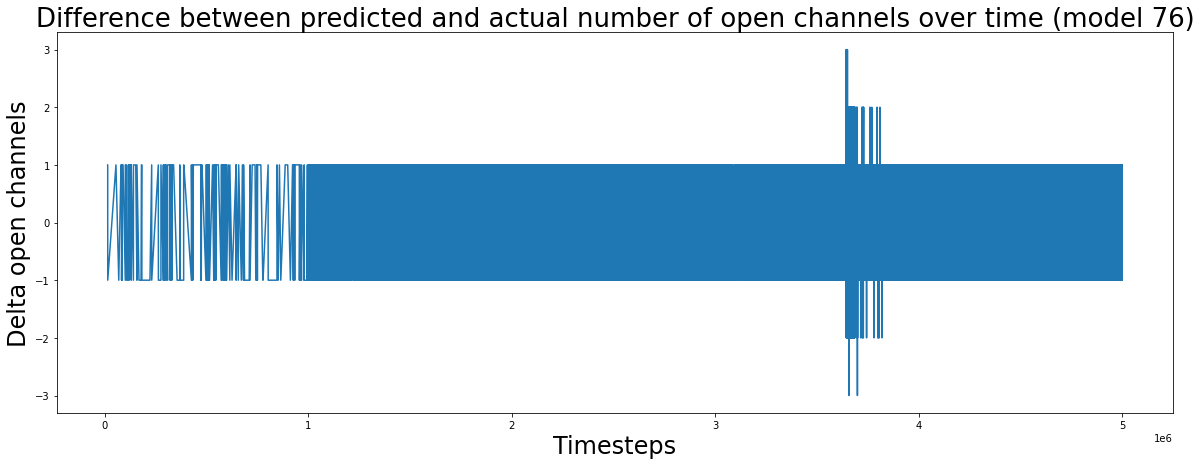

In [61]:
plt.figure(figsize=(20,7))
plt.plot(fail_df.difference_pred)
plt.title('Difference between predicted and actual number of open channels over time (model 76)', size =26)
plt.xlabel('Timesteps', size =24)
plt.ylabel('Delta open channels', size =24)

### Model 77
Use weights for the classes

In [49]:
train_weight = [ 24.8, 19.7, 11.1, 13.4, 8.1, 5.6, 3.8, 5.3, 4.9, 2.7, 0.7]

In [50]:
model3 = CatBoostClassifier(
    iterations=2500,
    class_weights= train_weight,
    learning_rate=0.05,
    depth= 10, 
    l2_leaf_reg= 9, 
    random_strength= 1, 
    bagging_temperature = 0.5,
    task_type = 'GPU',
    loss_function='MultiClass',
    custom_metric = 'TotalF1'

)
model3.fit(X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=500, 
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9348393	test: 1.9349237	best: 1.9349237 (0)	total: 290ms	remaining: 12m 4s
500:	learn: 0.0365378	test: 0.0385014	best: 0.0385014 (500)	total: 2m 15s	remaining: 8m 59s
1000:	learn: 0.0332705	test: 0.0376327	best: 0.0376327 (1000)	total: 4m 36s	remaining: 6m 54s
1500:	learn: 0.0309938	test: 0.0374335	best: 0.0374334 (1499)	total: 7m 2s	remaining: 4m 41s
2000:	learn: 0.0290910	test: 0.0373763	best: 0.0373756 (1981)	total: 9m 29s	remaining: 2m 22s
2499:	learn: 0.0274105	test: 0.0373733	best: 0.0373616 (2338)	total: 11m 57s	remaining: 0us
bestTest = 0.03736155218
bestIteration = 2338
Shrink model to first 2339 iterations.


In [51]:
# Evaluate model
pred = model3.predict(X_validation)
print("Macro F1 score: ", np.round(f1_score(y_validation, pred, average="macro"), 5))

Macro F1 score:  0.94599


In [52]:
# Score per batch
batch_f1_score(X, y, model3)                   

Macro F1 score batch 1s:  0.99779
Macro F1 score batch 1f:  0.99729
Macro F1 score batch 3:  0.98564
Macro F1 score batch 5:  0.98047
Macro F1 score batch 10:  0.90752


(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=int64),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=int64),
 array([[3],
        [3],
        [3],
        ...,
        [2],
        [1],
        [2]], dtype=int64),
 array([[5],
        [5],
        [5],
        ...,
        [4],
        [3],
        [3]], dtype=int64),
 array([[10],
        [10],
        [10],
        ...,
        [ 8],
        [ 9],
        [ 9]], dtype=int64))

In [53]:
# Is high_catpred important?
model3.get_feature_importance(prettified=True, type = 'PredictionValuesChange').head(10)

Feature Id  Importances
0                power2     7.978341
1                   exp     4.102083
2                sqroot     3.983956
3                signal     2.769938
4          high_catpred     2.060100
5                 lag+1     1.637603
6             mean_45_c     1.627107
7             max_405_r     1.600542
8  min_max_ratio_1215_c     1.528509
9             kurt_45_c     1.476414

In [54]:
# Predict open_channel for test set
X_test['open_channels']=model3.predict(X_test)

In [55]:
# Export results for submission
X_test[['time','open_channels']].to_csv('../reports/ion_submission_catclass3_2.1.9.csv', index=False, float_format='%.4f')
X_test.head()

time  signal  mean_5_r  mean_5_c   std_5_r   std_5_c  min_5_r  min_5_c  \
0  500.0001 -2.6513 -2.651300 -2.783900       NaN  0.114891  -2.6513  -2.8538   
1  500.0002 -2.8466 -2.748950 -2.698875  0.138098  0.194209  -2.8466  -2.8538   
2  500.0003 -2.8538 -2.783900 -2.681600  0.114891  0.172569  -2.8538  -2.8538   
3  500.0004 -2.4438 -2.698875 -2.665180  0.194209  0.179922  -2.8538  -2.8538   
4  500.0005 -2.6125 -2.681600 -2.643100  0.172569  0.157464  -2.8538  -2.8538   

   max_5_r  max_5_c  ...  deriv_lag-1  deriv_lag-3  deriv_lag+1  deriv_lag+3  \
0  -2.6513  -2.6513  ...          NaN          NaN     -0.10125      0.12065   
1  -2.6513  -2.4438  ...     -0.19530          NaN      0.20140     -0.06270   
2  -2.6513  -2.4438  ...     -0.10125          NaN      0.12065     -0.06185   
3  -2.4438  -2.4438  ...      0.20140     -0.19530     -0.06270     -0.10505   
4  -2.4438  -2.4438  ...      0.12065     -0.10125     -0.06185     -0.05210   

        exp  integration  integration_shift10  peak_detected  high_catpred  \
0  0.070559    -1.574542                  NaN          False             2   
1  0.058041    -3.344384                  NaN          False             2   
2  0.057625    -5.121426                  NaN          False             2   
3  0.086830    -6.488469                  NaN          False             3   
4  0.073351    -8.024211                  NaN          False             2   

   open_channels  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 141 columns]

In [56]:
# if need to export the new features change path 
#X_test[['time','signal', 'power2', 'exp', 'sqroot', 'high_catpred']].to_csv('../data/interim/test_high_catpred.csv', index=False, float_format='%.4f')
#train[['time','signal', 'power2', 'exp', 'sqroot','open_channels', 'high_catpred']].to_csv('../data/interim/train_high_catpred.csv', index=False, float_format='%.4f')